In [186]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [187]:
def eval_policy_better(env_, pi_, gamma_, t_max_, episodes_):
    env_.reset()

    v_pi_rep = np.empty(episodes_)
    for e in range(episodes_):
        s_t = env.reset()
        v_pi = 0
        for t in range(t_max_):
            a_t = pi_[s_t]
            s_t, r_t, done, info = env_.step(a_t) 
            v_pi += gamma_**t*r_t
            if done:
                break
        v_pi_rep[e] = v_pi
        env.close()
    return np.mean(v_pi_rep), np.min(v_pi_rep), np.max(v_pi_rep), np.std(v_pi_rep)

In [188]:
num_states = env.observation_space.n
num_actions = env.action_space.n

qtable = np.zeros((num_states,num_actions)) 
episodes = 2000
interactions = 100
epsilon = 0.99
alpha = 0.5
gamma = 0.9 
hist = [] 

# Main Q-learning loop
for episode in range(episodes):

    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for interact in range(interactions):
        # exploitation vs. exploratin by e-greedy sampling of actions
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(qtable[state,:])
        else:
            action = np.random.randint(0,num_actions)

        # Observe
        new_state, reward, done, info = env.step(action)

        # Update Q-table
        qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # Check if terminated
        if done == True: 
            break

    if episode % 10 == 0 or episode == 1:
        pi = np.argmax(qtable, axis=1)
        val_mean, val_min, val_max, val_std = eval_policy_better(env, pi, gamma, interactions, 1000)
        hist.append([episode, val_mean,val_min,val_max,val_std])


env.reset()

306

(201, 5)


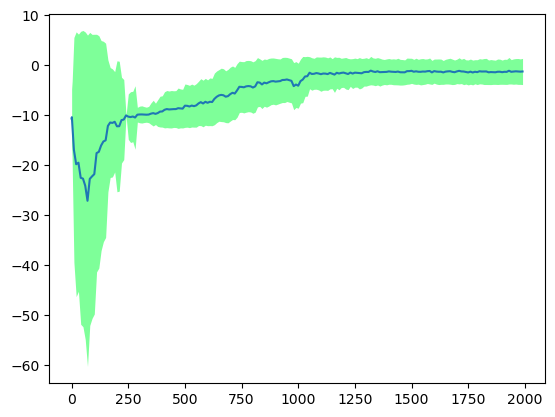

In [189]:
hist = np.array(hist)
print(hist.shape)

plt.plot(hist[:,0],hist[:,1])
plt.fill_between(hist[:,0], hist[:,1]-hist[:,4],hist[:,1]+hist[:,4],
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)
plt.show()

In [190]:
x = np.arange(0, 500)
x_one_hot = tf.keras.utils.to_categorical(x, num_classes=500)

max_indices = np.argmax(qtable, axis=1)
y_one_hot = np.eye(6)[max_indices]

In [191]:
model = tf.keras.models.Sequential([    
    tf.keras.layers.Input(shape=(num_states)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_actions, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                32064     
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dense_42 (Dense)            (None, 6)                 390       
                                                                 
Total params: 36,614
Trainable params: 36,614
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.fit(x_one_hot, y_one_hot, epochs = 40)

Epoch 1/40
16/16 [==============================] - 0s 2ms/step - loss: 1.7549
Epoch 2/40
16/16 [==============================] - 0s 2ms/step - loss: 1.6442
Epoch 3/40
16/16 [==============================] - 0s 2ms/step - loss: 1.5135
Epoch 4/40
16/16 [==============================] - 0s 2ms/step - loss: 1.3921
Epoch 5/40
16/16 [==============================] - 0s 2ms/step - loss: 1.3235
Epoch 6/40
16/16 [==============================] - 0s 2ms/step - loss: 1.2615
Epoch 7/40
16/16 [==============================] - 0s 2ms/step - loss: 1.1925
Epoch 8/40
16/16 [==============================] - 0s 2ms/step - loss: 1.1070
Epoch 9/40
16/16 [==============================] - 0s 2ms/step - loss: 0.9916
Epoch 10/40
16/16 [==============================] - 0s 2ms/step - loss: 0.8524
Epoch 11/40
16/16 [==============================] - 0s 2ms/step - loss: 0.7028
Epoch 12/40
16/16 [==============================] - 0s 2ms/step - loss: 0.5556
Epoch 13/40
16/16 [==============================

In [197]:
def eval_nn(q, e): 
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    episodes = e
    interactions = 100
    rewards = []

    for episode in range(episodes):

        state = env.reset()
        step = 0
        done = False
        total_rewards = 0

        for interact in range(interactions):
            if q:
                action = np.argmax(qtable[state,:])
            else: 
                one_hot = tf.one_hot(state, depth=500).numpy().reshape(1,500)
                action = np.argmax(model.predict(one_hot, verbose=0))

            new_state, reward, done, info = env.step(action)
            # Our new state is state
            state = new_state

            total_rewards += reward
            # Check if terminated
            if done == True: 
                break
        rewards.append(total_rewards)
    env.reset()  
    return sum(rewards)/episodes
    

In [198]:
e = 100
q = False
print("Average reward with NN", e ,"episodes =" ,eval_nn(q, e))
q = True
print("Average reward with qtable", e ,"episodes =" ,eval_nn(q, e))

Average reward with NN 100 episodes = 7.52
Average reward with qtable 100 episodes = 8.26
